In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore')

consumer_history = pd.read_csv('/kaggle/input/zb-da9-competition/ConsumerElectronics.csv')
ad_investment = pd.read_csv('/kaggle/input/zb-da9-competition/Media Investment.csv')
nps_stockindex = pd.read_csv('/kaggle/input/zb-da9-competition/NPS_Stockindex.csv')
promotion_data = pd.read_csv('/kaggle/input/zb-da9-competition/Special_Sale_Calendar.csv')

/kaggle/input/zb-da9-competition/Special_Sale_Calendar.csv
/kaggle/input/zb-da9-competition/ConsumerElectronics.csv
/kaggle/input/zb-da9-competition/NPS_Stockindex.csv
/kaggle/input/zb-da9-competition/Media Investment.csv


In [ ]:
consumer_history.head()

In [ ]:
consumer_history.info()

In [2]:
consumer_history.rename(columns= {'s1_fact.order_payment_type' : 'order_payment_type'}, inplace=True)
consumer_history['order_date'] = pd.to_datetime(consumer_history['order_date'])
consumer_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   fsn_id                           1648824 non-null  object        
 1   order_date                       1648824 non-null  datetime64[ns]
 2   Year                             1648824 non-null  int64         
 3   Month                            1648824 non-null  int64         
 4   order_id                         1648824 non-null  float64       
 5   order_item_id                    1648824 non-null  float64       
 6   gmv                              1648824 non-null  object        
 7   units                            1648824 non-null  int64         
 8   deliverybdays                    1648824 non-null  object        
 9   deliverycdays                    1648824 non-null  object        
 10  order_payment_type            

In [4]:
# 첫 구매 고객 계산
consumer_history['First_purchase'] = consumer_history.groupby(['cust_id'])['order_date'].transform('min')

# Cohort index 생성
consumer_history['Year'] = consumer_history['order_date'].dt.year
consumer_history['Month'] = consumer_history['order_date'].dt.month
consumer_history['First_Year'] = consumer_history['First_purchase'].dt.year
consumer_history['First_Month'] = consumer_history['First_purchase'].dt.month
consumer_history['cohortindex'] = (consumer_history['Year'] - consumer_history['First_Year']) * 12 + (consumer_history['Month'] - consumer_history['First_Month']) + 1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cohort_data = consumer_history.groupby(['First_Year', 'First_Month', 'cohortindex']).agg({'cust_id': 'nunique'}).reset_index()
cohort_pivot = cohort_data.pivot_table(index=['First_Year', 'First_Month'], columns='cohortindex', values='cust_id', fill_value=0)

# 코호트 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='g', cmap='YlGnBu', cbar_kws={'label': 'Number of New Customers'})
plt.title('Customer Cohort Analysis Heatmap')
plt.xlabel('Months Since First Purchase') # 첫 구매 이후 지난 개월
plt.ylabel('Year-Month of First Purchase') # 첫 구매 년도 - 월
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 분석 일자 추출 (2015년 09월 ~ 2016년 03월)
cohort_pivot = cohort_pivot.loc[(cohort_pivot.index.get_level_values('First_Year') == 2015) & 
                                (cohort_pivot.index.get_level_values('First_Month') >= 9) |
                                (cohort_pivot.index.get_level_values('First_Year') == 2016) & 
                                (cohort_pivot.index.get_level_values('First_Month') <= 3)]
# 첫 구매자 수 (0개월 차) 가져오기
cohort_sizes = cohort_pivot.iloc[:, 0]

In [ ]:
# 재구매율 계산
retention_rate = cohort_pivot.divide(cohort_sizes, axis=0) * 100

# 리텐션율 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Customer Cohort Retention Rate Heatmap')
plt.xlabel('Cohort Index (Months Since First Purchase)')
plt.ylabel('Cohort (Year-Month of First Purchase)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 이탈률 계산: 100%에서 재구매율을 뺀 값
purchase_Out_rate = 100 - retention_rate

# 이탈율 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(purchase_Out_rate, annot=True, fmt=".1f", cmap="Reds", cbar_kws={'label': 'Purchase Out Rate (%)'})
plt.title('Customer Purchase Out Rate Heatmap')
plt.xlabel('Cohort Index (Months Since Repurchase)')
plt.ylabel('Cohort (Year-Month of Repurchase)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 그룹 1: 첫 구매일이 2015-09 ~ 2015-11인 고객
group1 = consumer_history[(consumer_history['First_purchase'] >= '2015-09-01') &
                          (consumer_history['First_purchase'] <= '2015-11-30')]


# 그룹 2: 첫 구매일이 2015-12 ~ 2016-03인 고객
group2 = consumer_history[(consumer_history['First_purchase'] >= '2015-12-01') &
                          (consumer_history['First_purchase'] <= '2016-02-28')]

# 중복값 제거 후, 고객 ID만 추출
group1 = group1[['cust_id']].drop_duplicates()
group2 = group2[['cust_id']].drop_duplicates()

# 고객 ID 고유 개수 확인
display(group1.shape)  # 그룹 1의 고유 고객 수
display(group2.shape)  # 그룹 2의 고유 고객 수

### Group 1(첫 구매일이 2015-09 ~ 2015-11인 고객): 363,896명 - 첫 구매 이후 재구매가 현저히 낮은 그룹

### Group 2(첫 구매일이 2015-12 ~ 2016-03인 고객): 365,447명 - 첫 구매후 재구매 행동을 어느정도 보이는 그룹

In [5]:
consumer_history['order_date'].min() # 2015-05-19 13:42:09
consumer_history['order_date'].max() # 2016-07-25 01:19:45

# 2015-09-01 ~ 2016-03-31까지 데이터 필터링
consumer_history = consumer_history[consumer_history['order_date'] >= '2015-09-01']
consumer_history = consumer_history[consumer_history['order_date'] <= '2016-02-28']

# 필터링한 데이터에서 2016-03-30 23:59:25를 기준으로 설정
reference_date = consumer_history['order_date'].max()
print("기준 날짜 (Reference Date):", reference_date)

# 고객별 최근 거래 일자를 계산 (마지막 거래일)
consumer_history['last_order'] = consumer_history.groupby('cust_id')['order_date'].transform('max')

print(consumer_history['order_date'].min())
print(consumer_history['order_date'].max()) 


기준 날짜 (Reference Date): 2016-02-27 23:59:50
2015-09-01 00:00:57
2016-02-27 23:59:50


# RFM 분석

---

In [6]:
# 그룹 1: 첫 구매일이 2015-09-01 ~ 2015-11-30
group1 = consumer_history[(consumer_history['First_purchase'] >= '2015-09-01') &
                        (consumer_history['First_purchase'] <= '2015-11-30')]['cust_id'].unique()
group1_data = consumer_history[consumer_history['cust_id'].isin(group1)]

# 그룹 2: 첫 구매일이 2015-12-01 ~ 2016-02-28인 고객의 ID 목록
group2 = consumer_history[(consumer_history['First_purchase'] >= '2015-12-01') &
                        (consumer_history['First_purchase'] <= '2016-02-28')]['cust_id'].unique()
group2_data = consumer_history[consumer_history['cust_id'].isin(group2)]

In [7]:
display(group1_data.columns)
display(group2_data.columns)

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'deliverybdays', 'deliverycdays', 'order_payment_type',
       'sla', 'cust_id', 'pincode', 'product_analytic_super_category',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'product_mrp', 'product_procurement_sla',
       'First_purchase', 'First_Year', 'First_Month', 'cohortindex',
       'last_order'],
      dtype='object')

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'deliverybdays', 'deliverycdays', 'order_payment_type',
       'sla', 'cust_id', 'pincode', 'product_analytic_super_category',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'product_mrp', 'product_procurement_sla',
       'First_purchase', 'First_Year', 'First_Month', 'cohortindex',
       'last_order'],
      dtype='object')

In [8]:
consumer_history['gmv'] = consumer_history['gmv'].fillna(0)
consumer_history['gmv'] = pd.to_numeric(consumer_history['gmv'], errors='coerce').fillna(0)
consumer_history['gmv'] = consumer_history['gmv'].astype(int)

#gmv (Monetary) 값 확인: NaN, 0 또는 음수 값 제거
consumer_history = consumer_history[consumer_history['gmv'] > 0]

In [9]:
# reference_date (기준 날짜)
reference_date = pd.to_datetime("2016-02-28")

# Recency 계산
consumer_history['Recency'] = (reference_date - consumer_history['last_order']).dt.days

# 각 고객의 구매 빈도 계산 (주문 횟수)
frequency = consumer_history.groupby('cust_id')['order_date'].count().reset_index()
frequency.columns = ['cust_id', 'Frequency']

# 고객별 총 구매 금액 계산 
monetary = consumer_history.groupby('cust_id')['gmv'].sum().reset_index()
monetary.columns = ['cust_id', 'Monetary']

# Recency 데이터를 DataFrame으로 변환
recency = consumer_history[['cust_id', 'Recency']].drop_duplicates()

In [10]:
# Recency, Frequency, Monetary 데이터를 합침
rfm_df = recency.merge(frequency, on='cust_id', how='left')
rfm_df = rfm_df.merge(monetary, on='cust_id', how='left')

# rfm_df에서 중복된 행 제거
rfm_df = rfm_df.drop_duplicates(subset=['cust_id'])

# RFM 데이터 확인
print(rfm_df.head())
print(rfm_df.info())

                  cust_id  Recency  Frequency  Monetary
0  -1.01299130778588E+018      133          1      6400
1  -8.99032457905512E+018      131          2     10595
2   -1.0404429420466E+018      130          1      1990
3  -7.60496084352714E+018      136          2      1960
4    2.8945572083453E+018      133          1      1618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738142 entries, 0 to 738141
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cust_id    738142 non-null  object
 1   Recency    738142 non-null  int64 
 2   Frequency  738142 non-null  int64 
 3   Monetary   738142 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.5+ MB
None


In [11]:
# Group 1: 첫 구매일이 2015-09 ~ 2015-11인 고객
group1 = consumer_history[(consumer_history['First_purchase'] >= '2015-09-01') &
                          (consumer_history['First_purchase'] <= '2015-11-30')]

# Group 2: 첫 구매일이 2015-12 ~ 2016-02인 고객
group2 = consumer_history[(consumer_history['First_purchase'] >= '2015-12-01') &
                          (consumer_history['First_purchase'] <= '2016-02-28')]

# Group 1의 RFM 데이터 추출
group1 = group1['cust_id'].unique()
rfm_group1 = rfm_df[rfm_df['cust_id'].isin(group1)]

# Group 2의 RFM 데이터 추출
group2 = group2['cust_id'].unique()
rfm_group2 = rfm_df[rfm_df['cust_id'].isin(group2)]


In [12]:
# 소수점 2자리까지 출력
pd.options.display.float_format = '{:,.2f}'.format

# Group 1 RFM 통계
print("Group 1 RFM Summary:")
print(rfm_group1.describe())

# Group 2 RFM 통계
print("\nGroup 2 RFM Summary:")
print(rfm_group2.describe())

Group 1 RFM Summary:
         Recency  Frequency     Monetary
count 363,896.00 363,896.00   363,896.00
mean      131.75       1.46     3,369.03
std        23.14       0.89     9,663.59
min         0.00       1.00        39.00
25%       114.00       1.00       469.00
50%       134.00       1.00       999.00
75%       146.00       2.00     2,580.00
max       179.00      54.00 2,227,654.00

Group 2 RFM Summary:
         Recency  Frequency   Monetary
count 365,012.00 365,012.00 365,012.00
mean       43.19       1.18   3,088.53
std        26.19       0.70   8,400.41
min         0.00       1.00      10.00
25%        20.00       1.00     377.00
50%        43.00       1.00     829.00
75%        67.00       1.00   2,299.00
max        88.00      80.00 880,797.00


## [마지막 일자 = 2016-02-28] 그룹 1, 2의 count가 일치하여 두 그룹 간의 비교가 보다 신뢰성 있게 이루어질 수 있다.

### Group 1: 구매 빈도와 마지막 거래일이 상대적으로 더 오래된 경향을 보임, 재구매 비율이 낮은 그룹
- 마지막 거래일: 평균 131일전 / 최대 179일전
- 구매 빈도: 평균 1.4회 / 최대 54회 / 75%의 고객들이 '2회 구매'
- 구매 금액: 평균 3,369달러 / 최대 2,227,654달러

> 최근거래는 오래된 상태이지만 한 번 구매시 상대적으로 고가의 제품을 구매했거나 여러 제품을 한꺼번에 구입했을 가능성

### Group 2:구매 빈도는 낮지만 마지막 거래일이 더 최근에 집중, 재구매 행동이 이루어진 그룹
- 마지막 거래일: 평균 75일전 / 최대 120일전
- 구매 빈도: 평균 1.1회 / 최대 80회 / 75%의 고객들이 '1회 구매'
- 구매 금액: 평균 3,088달러 / 최대 880,797달러

> 비교적 최근 거래가 기준일에 가까운 점이 특징이며, 재구매를 시도하는 고객들이 존재한다.   

RFM으로 group에대한 검증완료(동일기간 검증 => 기존RFM구하는 방식은 보다 일찍 구매한 사람이 Recency나 Frequency수치가 높아 스코어에 패널티가 있는 상황이였기때문에, group1은 그룹max 2016 2-28 - last_order, group2 group max 2016-5-30 - last_order로 R,F스코어에 패널티를 없애고, 조금더 정밀한 세분화를 하려고함)
특징점이 그룹별로 나왔으니까 각 그룹별로 일단 Recency나 Frequency에 관련된 제품구매행동을 분석하고(재구매,할인율에 관련한 제품구매,배송시간 등) 
group1,2 에 대한 클러스터를 나눠 모범이 되는 클러스터와 조금 뒤쳐지는 클러스터에 관해 제품구매행동을 분석해서 특징점을 잡아 이에대한 개선포인트를 인사이트로 도출하려는 분석을 진행
구매빈도
평균구매가격대
상품가격대
조달시간
구매한 카테고리 비율, 그에 따른 할인율
이게 군집결과와 유의미한 차이가 나오면, 군집화보다는 그룹12로 묶어서 진행하는것이 낫다고 판단하였으나, 유의미한 차이가 나오지않음

### 마감날짜를 고정하고 RFM을 진행했기때문에  , 멘토님께서 지적해주신 Recency와 Frequency가 각 그룹이나 클러스터에서 다르게 나오는 문제가 해결되었다고 판단할수있고  group1 은 Frequency가 낮고 Recency는 높지만 , monetary가 높기때문에, 이 그룹은 재구매율을 높이는 해결방안이 있다 또한 여러개의 제품을 한꺼번에 구매하거나, 고가의 제품군을 구매했을 가능성이 높기때문에 프로모션의 프로모션의 효과또한 기대될것이다.  Group2는 
Group1의 구매자들의

In [25]:
group1 = consumer_history[(consumer_history['First_purchase'] >= '2015-09-01') &
                          (consumer_history['First_purchase'] <= '2015-11-30')]


In [15]:
group1=pd.DataFrame(group1)

In [46]:
rfm_group2

,cust_id,Recency,Frequency,Monetary
9096,-5.50337769581818E+017,24,1,384
11354,-7.44633420591305E+018,1,1,350
13849,-3.86462079897437E+018,8,1,350
14292,6.01769956065638E+018,37,1,1999
24183,-3.60945861972398E+018,6,1,199
...,...,...,...,...
685779,2.89465886947817E+018,5,2,1250
693912,-4.35637575887213E+018,5,2,678
698026,-4.01888932668041E+018,8,2,1118
704626,5.99171915122995E+018,38,2,650


In [22]:
group1=group1.merge(rfm_group1,on='cust_id',how='left')

In [47]:
group2 = consumer_history[(consumer_history['First_purchase'] >= '2015-12-01') &
                          (consumer_history['First_purchase'] <= '2016-02-28')]

In [48]:
group2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,First_purchase,First_Year,First_Month,cohortindex,last_order,Recency
9726,ACCDF2Z7KXGSZEP7,2016-02-03 14:39:53,2016,2,"4,415,891,349,854,800.00","4,415,891,349,854,800.00",384,1,5,6,...,GamingAccessory,GamePad,350,3,2016-02-03 14:39:53,2016,2,1,2016-02-03 14:39:53,24
12116,ACCDFZPGUWMVW54J,2016-02-26 18:33:43,2016,2,"1,415,227,360,754,800.00","1,415,227,360,754,800.00",350,1,\N,\N,...,Speaker,LaptopSpeaker,429,1,2016-02-26 18:33:43,2016,2,1,2016-02-26 18:33:43,1
14739,ACCDH8YRMYHYVCDT,2016-02-19 16:22:39,2016,2,"3,425,100,858,715,400.00","3,425,100,858,715,400.00",350,1,\N,\N,...,Speaker,LaptopSpeaker,650,4,2016-02-19 16:22:39,2016,2,1,2016-02-19 16:22:39,8
15202,ACCDHNVH8RDQQUBD,2016-01-21 15:00:47,2016,1,"2,424,487,915,484,300.00","2,424,487,915,484,300.00",1999,1,7,9,...,Speaker,MobileSpeaker,4999,4,2016-01-21 15:00:47,2016,1,1,2016-01-21 15:00:47,37
25979,ACCDRWPFRHEPRTKX,2016-02-21 20:59:09,2016,2,"2,419,579,543,033,200.00","2,419,579,543,033,200.00",199,1,7,9,...,HomeAudio,Dock,999,2,2016-02-21 20:59:09,2016,2,1,2016-02-21 20:59:09,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582627,ACCE5DGNU9JYBEGF,2016-02-22 12:05:38,2016,2,"3,397,027,939,485,300.00","3,397,027,939,485,300.00",625,1,\N,\N,...,CameraAccessory,Lens,575,2,2016-02-22 12:05:38,2016,2,1,2016-02-22 12:05:38,5
1592872,ACCE8FTB8ZTZHKHJ,2016-02-22 14:52:12,2016,2,"3,403,992,152,207,400.00","3,403,992,152,207,400.00",339,1,6,7,...,CameraAccessory,CameraTripod,1990,1,2016-02-22 14:52:12,2016,2,1,2016-02-22 14:52:12,5
1597675,ACCE8Q7PWJCCYWBA,2016-02-19 16:22:39,2016,2,"3,400,386,606,730,700.00","3,400,386,606,730,700.00",559,1,\N,\N,...,Speaker,MobileSpeaker,999,2,2016-02-19 16:22:39,2016,2,1,2016-02-19 16:22:39,8
1606165,ACCEAFH5HPN39MTK,2016-01-20 14:12:50,2016,1,"4,401,296,231,878,600.00","4,401,296,231,878,600.00",325,1,\N,\N,...,Speaker,LaptopSpeaker,599,2,2016-01-20 14:12:50,2016,1,1,2016-01-20 14:12:50,38


In [44]:
group2=group2.merge(rfm_group2,on='cust_id',how='left')

In [45]:
group2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_procurement_sla,First_purchase,First_Year,First_Month,cohortindex,last_order,Recency_x,Recency_y,Frequency,Monetary
0,ACCDF2Z7KXGSZEP7,2016-02-03 14:39:53,2016,2,"4,415,891,349,854,800.00","4,415,891,349,854,800.00",384,1,5,6,...,3,2016-02-03 14:39:53,2016,2,1,2016-02-03 14:39:53,24,24,1,384
1,ACCDFZPGUWMVW54J,2016-02-26 18:33:43,2016,2,"1,415,227,360,754,800.00","1,415,227,360,754,800.00",350,1,\N,\N,...,1,2016-02-26 18:33:43,2016,2,1,2016-02-26 18:33:43,1,1,1,350
2,ACCDH8YRMYHYVCDT,2016-02-19 16:22:39,2016,2,"3,425,100,858,715,400.00","3,425,100,858,715,400.00",350,1,\N,\N,...,4,2016-02-19 16:22:39,2016,2,1,2016-02-19 16:22:39,8,8,1,350
3,ACCDHNVH8RDQQUBD,2016-01-21 15:00:47,2016,1,"2,424,487,915,484,300.00","2,424,487,915,484,300.00",1999,1,7,9,...,4,2016-01-21 15:00:47,2016,1,1,2016-01-21 15:00:47,37,37,1,1999
4,ACCDRWPFRHEPRTKX,2016-02-21 20:59:09,2016,2,"2,419,579,543,033,200.00","2,419,579,543,033,200.00",199,1,7,9,...,2,2016-02-21 20:59:09,2016,2,1,2016-02-21 20:59:09,6,6,1,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432084,ACCE5DGNU9JYBEGF,2016-02-22 12:05:38,2016,2,"3,397,027,939,485,300.00","3,397,027,939,485,300.00",625,1,\N,\N,...,2,2016-02-22 12:05:38,2016,2,1,2016-02-22 12:05:38,5,5,2,1250
432085,ACCE8FTB8ZTZHKHJ,2016-02-22 14:52:12,2016,2,"3,403,992,152,207,400.00","3,403,992,152,207,400.00",339,1,6,7,...,1,2016-02-22 14:52:12,2016,2,1,2016-02-22 14:52:12,5,5,2,678
432086,ACCE8Q7PWJCCYWBA,2016-02-19 16:22:39,2016,2,"3,400,386,606,730,700.00","3,400,386,606,730,700.00",559,1,\N,\N,...,2,2016-02-19 16:22:39,2016,2,1,2016-02-19 16:22:39,8,8,2,1118
432087,ACCEAFH5HPN39MTK,2016-01-20 14:12:50,2016,1,"4,401,296,231,878,600.00","4,401,296,231,878,600.00",325,1,\N,\N,...,2,2016-01-20 14:12:50,2016,1,1,2016-01-20 14:12:50,38,38,2,650


In [26]:
group1.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,First_purchase,First_Year,First_Month,cohortindex,last_order,Recency
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,"3,419,300,926,147,000.00","3,419,300,926,147,000.00",6400,1,\N,\N,...,CameraAccessory,CameraTripod,7190,0,2015-10-17 15:11:54,2015,10,1,2015-10-17 15:11:54,133
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,"1,420,830,839,915,200.00","1,420,830,839,915,200.00",6900,1,\N,\N,...,CameraAccessory,CameraTripod,7190,0,2015-10-19 09:37:06,2015,10,1,2015-10-19 10:07:22,131
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,"2,421,912,925,714,800.00","2,421,912,925,714,800.00",1990,1,\N,\N,...,CameraAccessory,CameraTripod,2099,3,2015-10-20 15:45:56,2015,10,1,2015-10-20 15:45:56,130
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,"4,416,592,101,738,400.00","4,416,592,101,738,400.00",1690,1,\N,\N,...,CameraAccessory,CameraTripod,2099,3,2015-10-14 12:02:09,2015,10,1,2015-10-14 12:05:15,136
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,"4,419,525,153,426,400.00","4,419,525,153,426,400.00",1618,1,\N,\N,...,CameraAccessory,CameraTripod,2099,3,2015-10-17 21:25:03,2015,10,1,2015-10-17 21:25:03,133


In [20]:
rfm_group1=

,cust_id,Recency,Frequency,Monetary
0,-1.01299130778588E+018,133,1,6400
1,-8.99032457905512E+018,131,2,10595
2,-1.0404429420466E+018,130,1,1990
3,-7.60496084352714E+018,136,2,1960
4,2.8945572083453E+018,133,1,1618
...,...,...,...,...
738137,-9.90634340213633E+017,153,2,4400
738138,3.04892345453077E+018,152,2,4196
738139,-4.53140379455183E+018,151,2,4196
738140,-8.94046418180233E+018,151,2,4400


Basic Stats for Group 1:
 {'avg_recency': 135.87961996004358, 'median_recency': 134.0, 'avg_frequency': 416858, 'avg_monetary': 2302.6124133521007, 'median_monetary': 790.0}


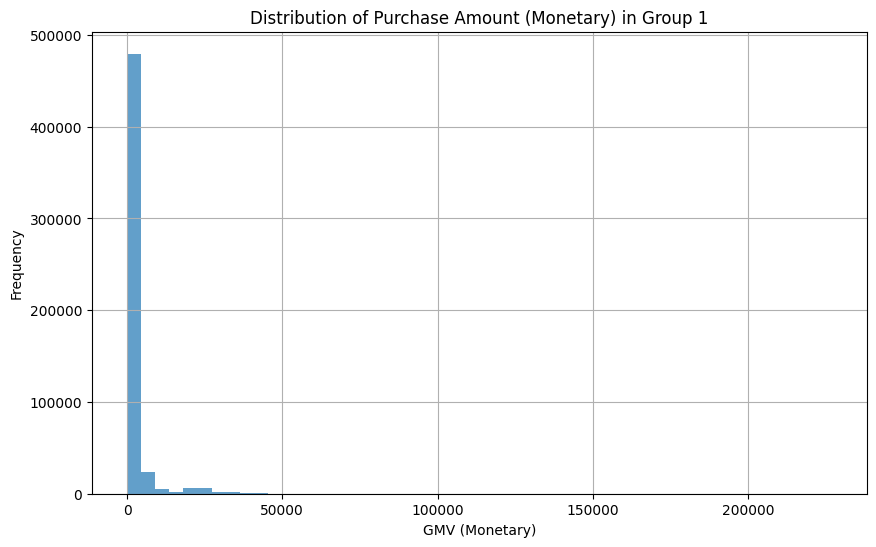

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 결측값 처리
# 주요 컬럼에서 결측값 제거 또는 대체
group1['Recency'] = group1['Recency'].fillna(group1['Recency'].median())
group1['gmv'] = group1['gmv'].fillna(group1['gmv'].median())

# Step 2: order_id의 고유 값 확인
if 'order_id' in group1.columns:
    # order_id가 문자열이나 숫자인지 확인
    group1['order_id'] = group1['order_id'].astype(str)

# Step 3: 기본 통계 계산
basic_stats = {
    'avg_recency': group1['Recency'].mean(),
    'median_recency': group1['Recency'].median(),
    'avg_frequency': group1['order_id'].nunique(),  # 고유 주문 수
    'avg_monetary': group1['gmv'].mean(),
    'median_monetary': group1['gmv'].median()
}

print("Basic Stats for Group 1:\n", basic_stats)

# Step 4: 구매 금액 분포 시각화
plt.figure(figsize=(10, 6))
group1['gmv'].dropna().hist(bins=50, alpha=0.7)
plt.title("Distribution of Purchase Amount (Monetary) in Group 1")
plt.xlabel("GMV (Monetary)")
plt.ylabel("Frequency")
plt.show()


Basic Stats for Group 2:
 {'avg_recency': 41.830217848637666, 'median_recency': 40.0, 'avg_frequency': 422113, 'avg_monetary': 2609.070765513586, 'median_monetary': 750.0}


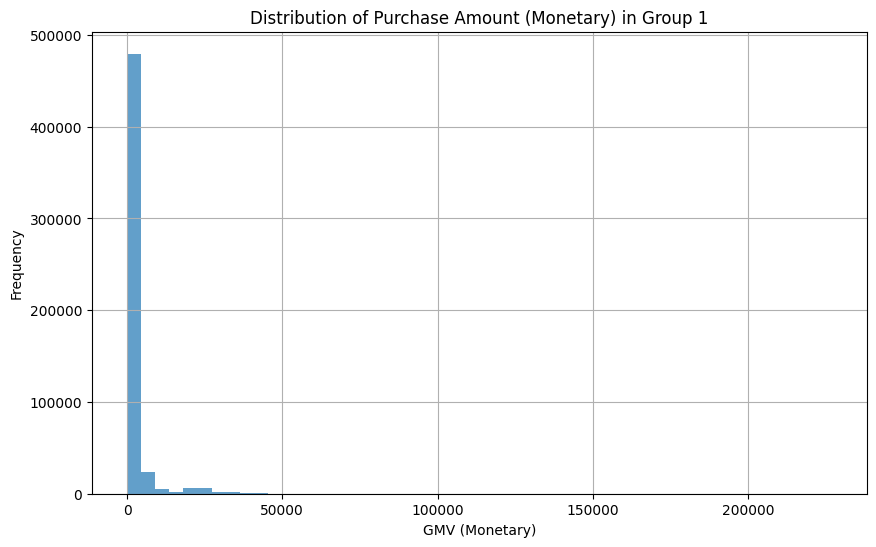

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 결측값 처리
# 주요 컬럼에서 결측값 제거 또는 대체
group2['Recency'] = group2['Recency'].fillna(group2['Recency'].median())
group2['gmv'] = group2['gmv'].fillna(group2['gmv'].median())

# Step 2: order_id의 고유 값 확인
if 'order_id' in group2.columns:
    # order_id가 문자열이나 숫자인지 확인
    group1['order_id'] = group1['order_id'].astype(str)

# Step 3: 기본 통계 계산
basic_stats = {
    'avg_recency': group2['Recency'].mean(),
    'median_recency': group2['Recency'].median(),
    'avg_frequency': group2['order_id'].nunique(),  # 고유 주문 수
    'avg_monetary': group2['gmv'].mean(),
    'median_monetary': group2['gmv'].median()
}

print("Basic Stats for Group 2:\n", basic_stats)

# Step 4: 구매 금액 분포 시각화
plt.figure(figsize=(10, 6))
group1['gmv'].dropna().hist(bins=50, alpha=0.7)
plt.title("Distribution of Purchase Amount (Monetary) in Group 1")
plt.xlabel("GMV (Monetary)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 결측값 처리
# 주요 컬럼에서 결측값 제거 또는 대체
group1['Recency'] = group2['Recency'].fillna(group1['Recency'].median())
group1['gmv'] = group2['gmv'].fillna(group1['gmv'].median())

# Step 2: order_id의 고유 값 확인
if 'order_id' in group1.columns:
    # order_id가 문자열이나 숫자인지 확인
    group1['order_id'] = group1['order_id'].astype(str)

# Step 3: 기본 통계 계산
basic_stats = {
    'avg_recency': group1['Recency'].mean(),
    'median_recency': group1['Recency'].median(),
    'avg_frequency': group1['order_id'].nunique(),  # 고유 주문 수
    'avg_monetary': group1['gmv'].mean(),
    'median_monetary': group1['gmv'].median()
}

print("Basic Stats for Group 1:\n", basic_stats)

# Step 4: 구매 금액 분포 시각화
plt.figure(figsize=(10, 6))
group1['gmv'].dropna().hist(bins=50, alpha=0.7)
plt.title("Distribution of Purchase Amount (Monetary) in Group 1")
plt.xlabel("GMV (Monetary)")
plt.ylabel("Frequency")
plt.show()


Basic Stats for Group 1:
                  Recency   order_id      gmv
avg_recency       135.88        NaN      NaN
median_recency    134.00        NaN      NaN
avg_frequency        NaN 416,858.00      NaN
avg_monetary         NaN        NaN 2,302.61
median_monetary      NaN        NaN   790.00


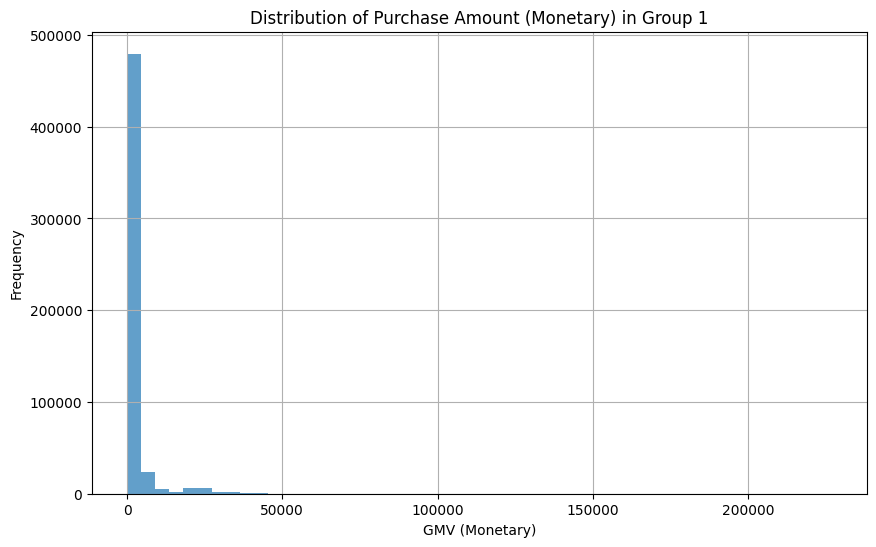

In [34]:
# 구매 행동 기본 통계
basic_stats = group1.agg(
    avg_recency=('Recency', 'mean'),
    median_recency=('Recency', 'median'),
    avg_frequency=('order_id', 'nunique'),
    avg_monetary=('gmv', 'mean'),
    median_monetary=('gmv', 'median')
)

print("Basic Stats for Group 1:\n", basic_stats)

# 구매 금액 분포
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
group1['gmv'].hist(bins=50, alpha=0.7)
plt.title("Distribution of Purchase Amount (Monetary) in Group 1")
plt.xlabel("GMV (Monetary)")
plt.ylabel("Frequency")
plt.show()


---

In [28]:
# 첫 구매 카테고리 분석
first_purchase_analysis = group1[group1['order_date'] == group1['First_purchase']].groupby('product_analytic_sub_category').agg(
    customer_count=('fsn_id', 'nunique'),
    avg_monetary=('gmv', 'mean')
).sort_values(by='customer_count', ascending=False)

print("First Purchase Analysis:\n", first_purchase_analysis)

# 첫 구매 시 할인율 계산
group1['discount_rate'] = ((group1['product_mrp'] - group1['gmv']) / group1['product_mrp']) * 100

first_purchase_discounts = group1[group1['order_date'] == group1['First_purchase']].agg(
    avg_discount_rate=('discount_rate', 'mean'),
    median_discount_rate=('discount_rate', 'median')
)

print("Discount Stats for First Purchase:\n", first_purchase_discounts)


First Purchase Analysis:
                                customer_count  avg_monetary
product_analytic_sub_category                              
CameraAccessory                          2253      1,252.43
Speaker                                  2218      1,130.41
GamingAccessory                          1129        793.65
TVVideoSmall                              676      1,352.04
HomeAudio                                 668      2,113.90
Game                                      631      1,942.06
AudioMP3Player                            625      1,370.74
Camera                                    366     15,863.17
GamingConsole                             208      7,908.61
AudioAccessory                            199      1,373.17
CameraStorage                             107      1,011.76
AmplifierReceiver                          60      1,838.67
HomeTheatre                                24      6,941.43
Discount Stats for First Purchase:
                       discount_rate
av

In [50]:
# 첫 구매 카테고리 분석
first_purchase_analysis = group2[group2['order_date'] == group2['First_purchase']].groupby('product_analytic_sub_category').agg(
    customer_count=('fsn_id', 'nunique'),
    avg_monetary=('gmv', 'mean')
).sort_values(by='customer_count', ascending=False)

print("First Purchase Analysis:\n", first_purchase_analysis)

# 첫 구매 시 할인율 계산
group1['discount_rate'] = ((group2['product_mrp'] - group2['gmv']) / group2['product_mrp']) * 100

first_purchase_discounts = group2[group2['order_date'] == group2['First_purchase']].agg(
    avg_discount_rate=('discount_rate', 'mean'),
    median_discount_rate=('discount_rate', 'median')
)

print("Discount Stats for First Purchase:\n", first_purchase_discounts)


First Purchase Analysis:
                                customer_count  avg_monetary
product_analytic_sub_category                              
Speaker                                  2818      1,091.45
CameraAccessory                          2469      1,198.58
GamingAccessory                          1504        736.64
Game                                      829      1,859.62
TVVideoSmall                              777      1,280.40
HomeAudio                                 757      2,170.61
AudioMP3Player                            639      1,233.48
Camera                                    383     17,922.85
AudioAccessory                            218      1,551.96
GamingConsole                             212     11,171.32
CameraStorage                             123        903.90
AmplifierReceiver                          62      1,520.79
HomeTheatre                                41      5,437.26


KeyError: "Column(s) ['discount_rate'] do not exist"

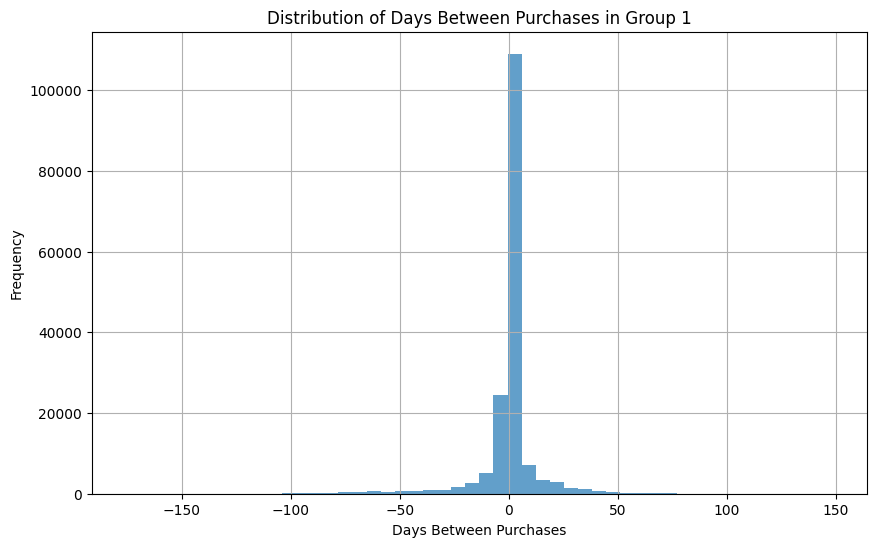

Top Products by Monetary Value:
                                avg_monetary  total_sales  purchase_count
product_analytic_sub_category                                           
Camera                            16,038.17    529227520           28386
GamingConsole                      8,417.65     50741577            4719
HomeTheatre                        6,765.70      8355644            1178
HomeAudio                          2,135.74     95318171           35518
Game                               1,987.56     58654790           22521
AmplifierReceiver                  1,957.50      3488272            1217
TVVideoSmall                       1,341.93     61279302           36287
AudioMP3Player                     1,338.49     49833321           28962
CameraAccessory                    1,311.97     93857087           53423
AudioAccessory                     1,309.73      4976973            2794


In [30]:
# 구매 간격 계산
group1['days_between_purchases'] = group1.groupby('cust_id')['order_date'].diff().dt.days

# 구매 간격 분포 시각화
plt.figure(figsize=(10, 6))
group1['days_between_purchases'].dropna().hist(bins=50, alpha=0.7)
plt.title("Distribution of Days Between Purchases in Group 1")
plt.xlabel("Days Between Purchases")
plt.ylabel("Frequency")
plt.show()

# 구매 금액이 높은 상위 상품 카테고리 분석
high_monetary_products = group1.groupby('product_analytic_sub_category').agg(
    avg_monetary=('gmv', 'mean'),
    total_sales=('gmv', 'sum'),
    purchase_count=('order_id', 'nunique')
).sort_values(by='avg_monetary', ascending=False)

print("Top Products by Monetary Value:\n", high_monetary_products.head(10))


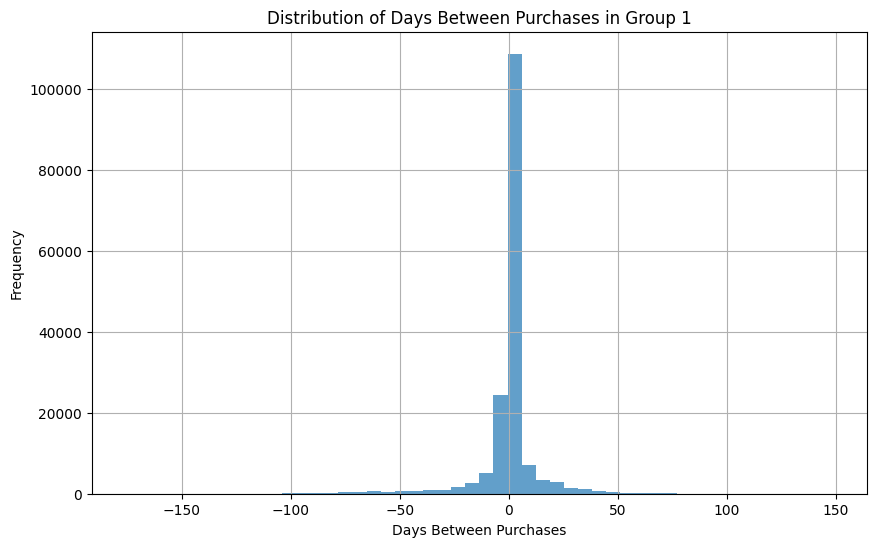

Top Products by Monetary Value:
                                avg_monetary  total_sales  purchase_count
product_analytic_sub_category                                           
Camera                            18,108.90    539373682           29612
GamingConsole                     11,888.98     90867436            7529
HomeTheatre                        5,435.66      4930144             906
HomeAudio                          2,170.97     78374339           35914
Game                               1,940.29     52036580           24849
AudioAccessory                     1,528.89      4523997            2882
AmplifierReceiver                  1,528.08      1462369             955
TVVideoSmall                       1,277.85     39090849           30298
CameraAccessory                    1,224.96     72045893           56647
AudioMP3Player                     1,224.54     36269527           29301


In [51]:
# 구매 간격 계산
group2['days_between_purchases'] = group2.groupby('cust_id')['order_date'].diff().dt.days

# 구매 간격 분포 시각화
plt.figure(figsize=(10, 6))
group1['days_between_purchases'].dropna().hist(bins=50, alpha=0.7)
plt.title("Distribution of Days Between Purchases in Group 1")
plt.xlabel("Days Between Purchases")
plt.ylabel("Frequency")
plt.show()

# 구매 금액이 높은 상위 상품 카테고리 분석
high_monetary_products = group2.groupby('product_analytic_sub_category').agg(
    avg_monetary=('gmv', 'mean'),
    total_sales=('gmv', 'sum'),
    purchase_count=('order_id', 'nunique')
).sort_values(by='avg_monetary', ascending=False)

print("Top Products by Monetary Value:\n", high_monetary_products.head(10))

In [32]:
import numpy as np

# product_mrp가 0이거나 NaN인 경우 필터링
group1 = group1[group1['product_mrp'] > 0].copy()

# 할인율 계산
group1['discount_rate'] = ((group1['product_mrp'] - group1['gmv']) / group1['product_mrp']) * 100

# inf 및 -inf 값을 NaN으로 처리
group1['discount_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값 제거
group1['discount_rate'].fillna(0, inplace=True)

# 카테고리별 할인율과 GMV의 상관관계 분석
category_discount_analysis = group1.groupby('product_analytic_sub_category').agg(
    avg_discount_rate=('discount_rate', 'mean'),
    avg_gmv=('gmv', 'mean'),
    total_sales=('gmv', 'sum')
).reset_index()

print("Category Discount Analysis:\n", category_discount_analysis)


Category Discount Analysis:
    product_analytic_sub_category  avg_discount_rate   avg_gmv  total_sales
0              AmplifierReceiver              43.73  1,957.50      3488272
1                 AudioAccessory              28.51  1,305.21      4945456
2                 AudioMP3Player              47.54  1,338.49     49833321
3                         Camera              30.25 16,015.08    521819235
4                CameraAccessory              45.72  1,316.48     93239493
5                  CameraStorage              42.43  1,047.57      5794105
6                           Game              24.13  1,995.97     58567688
7                GamingAccessory              39.98    824.04     49055894
8                  GamingConsole              30.68  8,418.22     50711381
9                      HomeAudio              36.00  2,135.85     95280217
10                   HomeTheatre              40.46  6,765.70      8355644
11                       Speaker              35.96  1,127.65    214735

In [ ]:
rfm_df.info()

In [ ]:
# Recency 계산
consumer_history['Recency'] = (reference_date - consumer_history['last_order']).dt.days

# 각 고객의 구매 빈도 계산 (주문 횟수)
frequency = consumer_history.groupby('cust_id')['order_date'].count().reset_index()
frequency.columns = ['cust_id', 'Frequency']

# 고객별 총 구매 금액 계산 
monetary = consumer_history.groupby('cust_id')['gmv'].sum().reset_index()
monetary.columns = ['cust_id', 'Monetary']

# Recency 데이터를 DataFrame으로 변환
recency = consumer_history[['cust_id', 'Recency']].drop_duplicates()

# Recency, Frequency, Monetary 데이터를 합침
rfm_df = recency.merge(frequency, on='cust_id', how='left')
rfm_df = rfm_df.merge(monetary, on='cust_id', how='left')

# rfm_df에서 중복된 행 제거
rfm_df = rfm_df.drop_duplicates(subset=['cust_id'])

# RFM 데이터 확인
print(rfm_df.head())

In [ ]:
# Frequency 값에 중복 제거
rfm_df['Frequency'] = rfm_df['Frequency'].astype(int)

# Recency 점수화 (값이 낮을수록 높은 점수)
recency_bins = [0, 30, 60, 100, np.inf]  # 0~30일 거래는 가장 최근, 120일 이상은 오래된 거래
recency_labels = [4, 3, 2, 1]  #4: 최근 거래 - 1: 예전거래 

rfm_df['Recency_Score'] = pd.cut(rfm_df['Recency'], bins=recency_bins, labels=recency_labels, include_lowest=True)


# Frequency를 4개의 구간으로 나누기 (적절한 bins 설정)
# 중복된 구간을 처리하기 위해 duplicates='drop'을 추가
frequency_bins = [0, 20, 40, 80, np.inf]  
frequency_labels = ['1', '2', '3', '4'] #4: 빈도 많음 - 1: 빈도 적음

rfm_df['Frequency_Score'] = pd.cut(rfm_df['Frequency'], bins=frequency_bins, labels=frequency_labels, include_lowest=True) 

# Monetary 점수화 (값이 높을수록 높은 점수)
monetary_bins = [0, 5000, 10000, 50000, np.inf]
monetary_labels = ['1', '2', '3', '4'] #4: 고지출 - 1: 저지출

rfm_df['Monetary_Score'] = pd.cut(rfm_df['Monetary'], bins=monetary_bins, labels=monetary_labels, include_lowest=True) 

# RFM 점수 결합 [444]: 우수 - [111]: 이탈
rfm_df['RFM_Score'] = rfm_df['Recency_Score'].astype(str) + rfm_df['Frequency_Score'].astype(str) + rfm_df['Monetary_Score'].astype(str)

# RFM 데이터 확인
rfm_df.head()

In [ ]:
# Recency를 기준으로 Group 1과 Group 2로 나누기 (기준을 평균으로 설정-최근 거래와 예전 거래 구분)
recency = rfm_df['Recency'].mean()
group_1 = rfm_df[rfm_df['Recency'] > recency] # 최근 거래일이 평균 보다 오래전
group_2 = rfm_df[rfm_df['Recency'] <= recency] # 최근 거래일이 평균 보다 가까움

In [ ]:
# Group 1 RFM 점수 계산
group_1['Recency_Score'] = pd.cut(group_1['Recency'], bins=recency_bins, labels=recency_labels, include_lowest=True)
group_1['Frequency_Score'] = pd.cut(group_1['Frequency'], bins=frequency_bins, labels=frequency_labels, include_lowest=True)
group_1['Monetary_Score'] = pd.qcut(group_1['Monetary'], 4, labels=[1, 2, 3, 4])

# Group 1 RFM 점수 결합
group_1['RFM_Score'] = group_1['Recency_Score'].astype(str) + group_1['Frequency_Score'].astype(str) + group_1['Monetary_Score'].astype(str)


In [ ]:
# Group 2 RFM 점수 계산
group_2['Recency_Score'] = pd.cut(group_2['Recency'], bins=recency_bins, labels=recency_labels, include_lowest=True)
group_2['Frequency_Score'] = pd.cut(group_2['Frequency'], bins=frequency_bins, labels=frequency_labels, include_lowest=True)
group_2['Monetary_Score'] = pd.qcut(group_2['Monetary'], 4, labels=[1, 2, 3, 4])

# Group 2 RFM 점수 결합
group_2['RFM_Score'] = group_2['Recency_Score'].astype(str) + group_2['Frequency_Score'].astype(str) + group_2['Monetary_Score'].astype(str)

In [ ]:
# 결과 확인
print("Group 1 RFM Summary:")
print(group_1[['cust_id', 'Recency', 'Frequency', 'Monetary', 'Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Score']].head())

print("Group 2 RFM Summary:")
print(group_2[['cust_id', 'Recency', 'Frequency', 'Monetary', 'Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Score']].head())

특징:
* 두 그룹 모두 거래 빈도가 1회에 마무리 됨 (F 저조)
* 그룹 1은 최근 거래일이 오래전 이지만 구매 금액이 상당히 높음 (R 저조 / M 최고 수준) = 그룹 내에서
  >이탈 고객으로 분석 : 재참여 유도
* 그룹 2은 최근 거래일이 비교적 가깝고 구매 금액도 높음 (R 높음 / M 높음) = 그룹 내에서
  >활성 고객으로 분석 : 충성도 강화 및 리텐션 전략

---

## 클러스터링(군집화) : 데이터에서 숨겨진 패턴이나 구조를 발견하고, 각 데이터 포인트를 적절한 군집에 할당하는 과정으로  거리 기반 알고리즘에서는 서로 다른 단위나 범위를 가진 변수들이 같은 비중으로 비교될 수 있도록 맞춰주는 것이 필요하다

정규 분포 확인 :

정규 분포 여부는 데이터가 평균을 중심으로
대칭적인 분포를 가지는지를 확인함으로써 평가할 수 있

* Q-Q Plot - 데이터가 대각선에 가까운 직선 형태를 띠면 정규 분포를 따를 가능성이 높다.다.

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(rfm_df['Recency'], dist="norm", plot=plt)
plt.show()

stats.probplot(rfm_df['Frequency'], dist="norm", plot=plt)
plt.show()

stats.probplot(rfm_df['Monetary'], dist="norm", plot=plt)
plt.show()

In [ ]:
# StandardScaler 변수들이 평균이 0, 표준편차가 1이 되도록 변환 / 데이터가 정규 분포를 따르는 경우에 적합
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_standardized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

In [ ]:
print(group_1.info())
print(group_2.info())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recency vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Recency', y='Frequency', data=rfm_df, palette='Set1')
plt.title('Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# Recency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Recency', y='Monetary', data=rfm_df, palette='Set1')
plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

# Frequency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm_df, palette='Set1')
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

K-means: 군집 중심(centroid)을 최적화하는 방식
- 군집이 구형이거나 규모가 균등할 때 효과적입니다.
- 군집 수(K)를 미리 정할 수 있을 때 사용합니다.

DBSCAN: 밀도 기반 군집화 알고리즘으로, 데이터의 밀도가 높은 지역을 군집으로 인식하고, 밀도가 낮은 지역을 노이즈로 간주합니다.
- 군집의 형태가 불규칙하고, 이상치가 있을 경우 유용합니다.
- 군집 수를 미리 지정할 필요가 없으며, 밀도 기반으로 클러스터를 찾습니다.

In [ ]:
from sklearn.cluster import KMeans

# K-means 클러스터링 적용
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_standardized)

In [ ]:
group_1.info()

In [ ]:
# 그룹 1 데이터와 그룹 2 데이터를 따로 클러스터링 진행
group1_rfm = group_1[['Recency', 'Frequency', 'Monetary']]  # 그룹 1의 RFM 데이터
group2_rfm = group_2[['Recency', 'Frequency', 'Monetary']]  # 그룹 2의 RFM 데이터

In [ ]:
# 데이터 표준화 (StandardScaler)
scaler = StandardScaler()
group1_standardized = scaler.fit_transform(group1_rfm)
group2_standardized = scaler.fit_transform(group2_rfm)

In [ ]:
# 엘보우 방법을 사용하여 군집 수(K) 결정 (그룹 1)
inertia_values_group1 = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(group1_standardized)
    inertia_values_group1.append(kmeans.inertia_)

# 엘보우 그래프 그리기 (그룹 1)
plt.plot(k_range, inertia_values_group1, marker='o')
plt.title('Elbow Method - Group 1')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# 엘보우 방법을 사용하여 군집 수(K) 결정 (그룹 2)
inertia_values_group2 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(group2_standardized)
    inertia_values_group2.append(kmeans.inertia_)

# 엘보우 그래프 그리기 (그룹 2)
plt.plot(k_range, inertia_values_group2, marker='o')
plt.title('Elbow Method - Group 2')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# 최적 군집 수를 찾은 후 (예: K=4) 각 그룹에 대해 K-means 클러스터링 진행
kmeans_group1 = KMeans(n_clusters=4, random_state=42)
group_1['Cluster'] = kmeans_group1.fit_predict(group1_standardized)

kmeans_group2 = KMeans(n_clusters=4, random_state=42)
group_2['Cluster'] = kmeans_group2.fit_predict(group2_standardized)

In [ ]:
# 각 그룹의 클러스터링 결과 확인 (예시로 Recency vs Monetary 시각화)
plt.figure(figsize=(8, 6))
for cluster in sorted(group_1['Cluster'].unique()):
    cluster_data = group_1[group_1['Cluster'] == cluster]
    plt.scatter(cluster_data['Recency'], cluster_data['Monetary'], label=f'Cluster {cluster}')
plt.title('Cluster Plot - Group 1')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
for cluster in sorted(group_2['Cluster'].unique()):
    cluster_data = group_2[group_2['Cluster'] == cluster]
    plt.scatter(cluster_data['Recency'], cluster_data['Monetary'], label=f'Cluster {cluster}')
plt.title('Cluster Plot - Group 2')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.colorbar()
plt.show()

In [ ]:
# Group 1 클러스터별 RFM 평균 계산
group1_cluster_summary = group_1.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'Recency': 'Avg_Recency', 'Frequency': 'Avg_Frequency', 'Monetary': 'Avg_Monetary'})

print("Group 1 Cluster Summary:")
print(group1_cluster_summary)

#### Group 1: 구매 빈도와 마지막 거래일이 상대적으로 더 오래된 경향을 보임, 재구매 비율이 낮은 그룹 

[평균값]- 클러스터 0: (127일 전)(횟수 1.4회)(32,294 달러) || **최근 거래는 오래되었지만, 구매금액이 매우 높은 고객**
- 클러스터 1: (134일 전)(횟수 4회)(6,053 달러) || **최근 거래는 오래되었지만, 비교적 높은 거래 빈도를 가진 고객**
- 클러스터 2: (121일 전)(횟수 1.1회)(1,486 달러) || **거래가 매우 드물고 구매 금액이 낮은 고객**
- 클러스터 3: (164일 전)(횟수 2회)(2,738달러) || **거래일이 매우 오래되고 구매 빈도는 낮지만 중간 정도의 구매 금액을 가진 고객**

[RFM 특징]
* 그룹 1은 최근 거래일이 오래전 이지만 구매 금액이 상당히 높음 (R 저조 / M 최고 수준) = 그룹 내에서
  >이탈 고객으로 분석 : 재참여 유도


In [ ]:
# Group 2 클러스터별 RFM 평균 계산
group2_cluster_summary = group_2.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'Recency': 'Avg_Recency', 'Frequency': 'Avg_Frequency', 'Monetary': 'Avg_Monetary'})

print("Group 2 Cluster Summary:")
print(group2_cluster_summary)

#### Group 2: 구매 빈도는 낮지만 마지막 거래일이 더 최근에 집중, 재구매 행동이 이루어진 그룹

[평균값]
- 클러스터 0: (65일 전)(횟수 1.1회)(1,560 달러) || **최근 거래가 이루어졌지만, 구매 빈도와 금액은 다소 낮은 고객**
- 클러스터 1: (20일 전)(횟수 1.2회)(1,508 달러) || **매우 최근에 거래를 한 고객으로 구매 빈도와 금액이 중간 정도**
- 클러스터 2: (43일 전)(횟수 1.4회)(27,335 달러) || **중간 정도의 거래 빈도를 보이며, 상당히 높은 구매 금액을 가진 고객**
- 클러스터 3: (34일 전)(횟수 10회)(87,225달러) || **높은 구매 빈도와 구매 금액을 보이며, 최근 거래가 이루어진 VIP 고객**

[RFM 특징]
* 그룹 2은 최근 거래일이 비교적 가깝고 구매 금액도 높음 (R 높음 / M 높음) = 그룹 내에서
  >활성 고객으로 분석 : 충성도 강화 및 리텐션 전략

In [ ]:
# Group 1 클러스터별 RFM 분포
print("Group 1 RFM Distribution by Cluster:")
for cluster in group_1['Cluster'].unique():
    print(f"\nCluster {cluster} RFM Distribution:")
    print(group_1[group_1['Cluster'] == cluster][['Recency', 'Frequency', 'Monetary']].describe())

# Group 2 클러스터별 RFM 분포
print("Group 2 RFM Distribution by Cluster:")
for cluster in group_2['Cluster'].unique():
    print(f"\nCluster {cluster} RFM Distribution:")
    print(group_2[group_2['Cluster'] == cluster][['Recency', 'Frequency', 'Monetary']].describe())

[Group 1] = 이탈 그룹 : 활성화 그룹으로 전환

[Group 2] = 활성화 그룹 : 충성 고객 그룹으로 전환

## 목표: 매출 증대와 재구매율 상승
### 타켓 : Group 2 : 최근 거래와 재구매 행동이 이루어진 활성화 그룹을, 충성 고객 그룹으로 전환하여 매출 증대와 재구매율 상승

---

**Group 2 Cluster Summary:**

| Cluster | Avg_Recency | Avg_Frequency | Avg_Monetary |
|---------|-------------|---------------|--------------|
| 0       | 65.43       | 1.12          | 1,560.02     |
| 1       | 20.21       | 1.20          | 1,508.66     |
| 2       | 43.03       | 1.48          | 27,335.49    |
| 3       | 33.91       | 10.53         | 87,225.82    |


#### 1. 각 클러스터 별 구매 시기 (24시간 집계)

In [ ]:
consumer_history.info()

In [ ]:
group_2.info()

In [ ]:
# rfm_df에서 'cust_id'와 'Cluster' 컬럼이 제대로 존재하는지 확인
print(rfm_df.columns)  # 컬럼명 출력

# group_2에서 'Cluster' 컬럼이 제대로 존재하는지 확인
print(group_2.columns)  # 컬럼명 출력

In [ ]:
# group_2에서 'cust_id'를 이용해 unique한 고객 ID 목록을 추출
group_2_customers = group_2['cust_id'].unique()

# consumer_history에서 해당 고객들의 구매 이력 필터링
group_2_history = consumer_history[consumer_history['cust_id'].isin(group_2_customers)]

# 병합된 group_2 데이터프레임에서 'Cluster' 컬럼을 'Cluster_rfm'으로 변경하여 병합
group_2_history = group_2_history.merge(group_2[['cust_id', 'Cluster']], on='cust_id', how='left', suffixes=('', '_rfm'))

# 병합 후 데이터 확인
print(group_2_history.info())  # 병합된 데이터프레임의 정보 확인

In [ ]:
# 추가 분석을 위해 'Hour' 컬럼 생성 (구매 시각 추출)
group_2_history['Hour'] = group_2_history['order_date'].dt.hour  # 구매 시각을 'Hour' 컬럼으로 생성

# 클러스터별 시간대별 구매 건수 집계
hourly_purchases = group_2_history.groupby(['Cluster', 'Hour']).size().reset_index(name='Purchase_Count')


In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=hourly_purchases, x='Hour', y='Purchase_Count', hue='Cluster', marker='o', palette='Set1')
plt.title('Group 2 Clusters: Hourly Purchase Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Purchases')
plt.xticks(range(0, 24))
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### 1. 각 클러스터 별 구매 시기 (24시간 집계)
- 클러스터 0 / 클러스터 1: 비슷한 양상을 보이며, 낮 12시 이후부터 구매활동이 있으며, 21시에 높은 활동을 시도
  >광고나 프로모션을 21시경에 집중하는 전략
  
- 클러스터 2 / 클러스터 3: 비슷한 양상을 보이며, 특징적인 활동 시간 확인이 모호함
- >특정 시간대를 설정하는 것 보다 하루 종일 꾸준한 광고 노출이 효과적일 수 있다.

---

#### 2. 각 클러스터 별 선호 제품

In [ ]:
print(group_2_history['product_analytic_category'].unique())
print(group_2_history['product_analytic_sub_category'].unique()) # 해당 카테고리 선택
print(group_2_history['product_analytic_vertical'].unique())

In [ ]:
# 각 클러스터별로 제품 카테고리 별 구매 건수 집계
product_preferences = group_2_history.groupby(['Cluster', 'product_analytic_sub_category']).size().reset_index(name='Purchase_Count')

# 각 클러스터별로 상위 5개 선호 제품 카테고리 추출
top_products_per_cluster = product_preferences.groupby('Cluster').apply(lambda x: x.nlargest(5, 'Purchase_Count')).reset_index(drop=True)

print(top_products_per_cluster)

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top_products_per_cluster, x='product_analytic_sub_category', y='Purchase_Count', hue='Cluster')
plt.title('Top 5 Preferred Products by Cluster')
plt.xlabel('Product Category')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()

#### 2. 각 클러스터 별 선호 제품 (product_analytic_sub_category)
- 클러스터 0 / 클러스터 1: 스피커 제품군 구매가 약 7만 건으로 가장 높고, 게임 액세서리와 카메라 액세서리는 약 3만 건, 홈 오디오는 약 1,7000건으로 확인되었다.
  > 스피커, 게임 액세서리, 카메라 액세서리, 오디오 제품에 대한 광고나 할인 및 가격 조정 정책을 시행
  
- 클러스터 2 / 클러스터 3: 특징적인 부분이 없고, 미약하나 클러스터 2에서 카메라 제품에 대한 구매가 약 18,000건으로 확인되었다.
  > 우수고객과 VIP 고객 그룹군으로 새로운 로얄티 제공 프로그램을 수립

---

#### 3. 각 클러스터 별 선호 가격대

In [ ]:
# 제품 가격 (product_mrp)을 이용하여 가격대 구간 나누기
price_bins = [0, 5000, 10000, 15000, 20000, 50000, 100000]  # 가격대 구간 (예시)
price_labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-50000', '50000-100000']
group_2_history['Price_Range'] = pd.cut(group_2_history['product_mrp'], bins=price_bins, labels=price_labels, right=False)

# 각 클러스터별 선호 가격대 집계
price_range_preferences = group_2_history.groupby(['Cluster', 'Price_Range']).size().reset_index(name='Purchase_Count')
print(price_range_preferences)


In [ ]:
# 각 클러스터별로 선호 가격대 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=price_range_preferences, x='Price_Range', y='Purchase_Count', hue='Cluster')
plt.title('Preferred Price Range by Cluster')
plt.xlabel('Price Range')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()

#### 2. 각 클러스터 별 선호 가격대
- 클러스터 0 / 클러스터 1: 0-5000달러 가격대에서 높은 구매 건수(저가 제품 선호), 고가 제품에 대한 관심은 낮음
  > 기간 한정 할인이나 묶음 할인을 제공하여 구매를 촉진
  
- 클러스터 2: 20000-50000달러 가격대에서 높은 구매 건수(고가 제품 선호)
  > VIP 프로그램을 통한 전용 할인이나 특별한 혜택 제공
  
- 클러스터 3
  

In [ ]:
# 가격 구간대
bins = [0, 5000, 10000, 20000, 50000]
labels = ['0-5000', '5000-10000', '10000-20000', '20000-50000']

# 'product_mrp' 컬럼을 기반으로 가격대 구분
consumer_history['Price_Range'] = pd.cut(consumer_history['product_mrp'], bins=bins, labels=labels, right=False)

# group_2와 consumer_history 병합
group_2_with_history = group_2.merge(consumer_history[['cust_id', 'product_analytic_sub_category', 'Price_Range']], on='cust_id', how='left')

# 각 클러스터 별로 선호 제품군과 가격대 분석
cluster_preference = group_2_with_history.groupby(['Cluster', 'product_analytic_sub_category', 'Price_Range']).size().reset_index(name='Purchase_Count')

# 결과 출력 (각 클러스터별 선호 제품군과 가격대별 구매 건수)
print(cluster_preference)

In [ ]:
# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_preference, x='Price_Range', y='Purchase_Count', hue='product_analytic_sub_category', ci=None)
plt.title('Preferred Product Categories by Price Range for Each Cluster')
plt.xlabel('Price Range')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### 2. 각 클러스터 별 선호 제품 + 3. 각 클러스터 별 선호 가격대 대한 정보

- 클러스터 0 / 클러스터 1: 낮은 가격대에 존재하는 스피커, 게임 액세서리, 카메라 액세서리, 오디오 제품 선호도가 높음
- 클러스터 2: 높은 가격대에 존재하는 카메라 제품 선호도가 높음
- 클러스터 3: VIP 그룹은 현재까지 선호하는 제품 및 가격대 파악 모호

---

4. 각 클러스터 별 할인율에 따른 매출 / 재구매율 계산

In [ ]:
group_2_history.info()

In [ ]:
# 1. product_mrp만 적용했을 때 매출과 재구매율 계산
# 각 클러스터별로 product_mrp 기준으로 매출(gmv) 계산
cluster_sales_mrp = group_2_history.groupby('Cluster').agg(
    Total_Original_Sales=('gmv', 'sum'),  # 전체 매출
    Transaction_Count=('order_id', 'nunique')  # 고유 거래 수
).reset_index()

# 각 클러스터별 재구매율 계산 (재구매 고객 수 / 전체 고객 수)
repurchase_rate_by_cluster = []

# 각 클러스터별로 데이터를 분리하여 처리
for cluster_id in group_2_history['Cluster'].unique():
    cluster_data = group_2_history[group_2_history['Cluster'] == cluster_id]
    
    # 해당 클러스터 내에서 첫 번째 구매가 여러 번인 고객 찾기
    repeated_customers = cluster_data.groupby('cust_id').filter(lambda x: len(x) > 1)
    
    # 재구매 고객 수와 전체 고객 수 계산
    repeated_customers_count = repeated_customers['cust_id'].nunique()
    total_customers_count = cluster_data['cust_id'].nunique()
    
    # 재구매율 계산
    repurchase_rate = repeated_customers_count / total_customers_count
    
    # 결과 저장
    repurchase_rate_by_cluster.append({'Cluster': cluster_id, 'Repurchase_Rate': repurchase_rate})

# 결과를 DataFrame으로 변환
repurchase_rate_df = pd.DataFrame(repurchase_rate_by_cluster)

In [ ]:
# 클러스터별 매출과 재구매율을 합친 결과
cluster_sales_mrp = cluster_sales_mrp.merge(repurchase_rate_df, on='Cluster')

# 결과 출력
print("Cluster-wise Sales and Repurchase Rate (based on product_mrp):")
print(cluster_sales_mrp)

In [ ]:
# 2. 할인율 적용 시 매출과 재구매율 계산
# 할인율 계산: (product_mrp - gmv) / product_mrp * 100
group_2_history['discount_rate'] = ((group_2_history['product_mrp'] - group_2_history['gmv']) / group_2_history['product_mrp']) * 100

# 할인율이 -inf, inf인 값은 NaN으로 처리
group_2_history['discount_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 할인율이 0보다 큰 값들(할인 적용된 데이터)만을 대상으로 매출과 거래 빈도 계산
discounted_sales = group_2_history[group_2_history['discount_rate'] > 0]
non_discounted_sales = group_2_history[group_2_history['discount_rate'] == 0]

# 할인율 적용 후 클러스터별 매출 계산
cluster_sales_discounted = discounted_sales.groupby('Cluster').agg(
    Discounted_Sales=('gmv', 'sum'),  # 할인된 매출
    Discounted_Transaction_Count=('order_id', 'nunique')  # 할인된 거래 수
).reset_index()

# 재구매율 계산 (할인 적용 후)
# 할인된 거래들에 대해서 재구매율을 계산
discounted_repeated_customers = discounted_sales.groupby('cust_id').filter(lambda x: len(x) > 1)
discounted_repeated_customers_count = discounted_repeated_customers['cust_id'].nunique()
discounted_repurchase_rate = discounted_repeated_customers_count / discounted_sales['cust_id'].nunique()

# 결과 출력
print("Cluster-wise Sales and Transaction Count with Discount:")
print(cluster_sales_discounted)
print("\nRepurchase Rate (with Discount):", discounted_repurchase_rate)

In [ ]:
from scipy import stats

# 3. 할인율이 매출과 재구매에 미치는 영향에 대한 t-검정

# 매출(gmv) 차이에 대한 t-검정 (할인 적용된 그룹 vs 비적용된 그룹)
t_stat_gmv, p_value_gmv = stats.ttest_ind(discounted_sales['gmv'], non_discounted_sales['gmv'], equal_var=False)

# 재구매율에 대한 t-검정: 재구매율 계산 (할인 적용된 그룹 vs 비적용된 그룹)
# 할인된 매출에서 재구매율을 계산하고, 비할인 그룹의 재구매율과 비교
# 할인 적용 여부에 따라 재구매 고객 수를 계산

# 할인된 그룹의 재구매율
discounted_repurchase_rate = discounted_repeated_customers['cust_id'].nunique() / discounted_sales['cust_id'].nunique()

# 비할인 그룹의 재구매율
non_discounted_repeated_customers = non_discounted_sales.groupby('cust_id').filter(lambda x: len(x) > 1)
non_discounted_repurchase_rate = non_discounted_repeated_customers['cust_id'].nunique() / non_discounted_sales['cust_id'].nunique()

# t-검정: 할인된 재구매율과 비할인 재구매율 차이 비교
t_stat_repurchase, p_value_repurchase = stats.ttest_ind(discounted_repurchase_rate, non_discounted_repurchase_rate)

# 결과 출력
print("\nT-test Result for GMV (Sales):")
print("t-statistic:", t_stat_gmv, ", p-value:", p_value_gmv)

print("\nT-test Result for Repurchase Rate:")
print("t-statistic:", t_stat_repurchase, ", p-value:", p_value_repurchase)

In [ ]:
# 각 클러스터별 미할인 매출과 할인 적용 매출
cluster_sales_data = {
    'Cluster': [0, 1, 2, 3],
    'Total_Sales_No_Discount': [264264996, 258497577, 560568914, 55126719],
    'Total_Sales_With_Discount': [251637001, 245879310, 537154723, 44731038]
}

# 데이터프레임으로 변환
import pandas as pd

cluster_sales_df = pd.DataFrame(cluster_sales_data)

# 매출 하락 비율 계산
cluster_sales_df['Sales_Decrease_Rate (%)'] = ((cluster_sales_df['Total_Sales_No_Discount'] - cluster_sales_df['Total_Sales_With_Discount']) / cluster_sales_df['Total_Sales_No_Discount']) * 100

# 결과 출력
print(cluster_sales_df[['Cluster', 'Sales_Decrease_Rate (%)']])

#### 4. 각 클러스터 별 할인율에 따른 매출 / 재구매율 계산

                 
|클러스터 | 총 매출(미할인) | 총 매출(할인 적용) | 매출 하락 비중(%) |
|---------|-------------|---------------|---------------|
| 0       | 264,264,996       | 251,637,001   | 4.78 |
| 1       | 258,497,577       | 245,879,310   | 4.88 |
| 2       | 560,568,914       | 537,154,723   | 4.18 | 
| 3       | 55,126,719        | 44,731,038    | 18.86|

- 할인이 매출에 미치는 영향으로는 p-value가 0.05보다 작은 값 (p-value = 0.0089)으로 나온 결과에서 할인이 매출에 유의미한 영향을 미친다고 결론을 내릴 수 있다.
- 코호트 분석에서 재구매율이 5.5% 미만으로 나타났음으로 할인과 재구매율 간에 유의미한 상관관계가 없을 가능성이 높다.

---

5. 각 클러스터 별 최적 배송시간

In [ ]:
group_2_history.head()

In [ ]:
# \N을 NaN으로 변환
group_2_history['deliverybdays'] = group_2_history['deliverybdays'].replace('\\N', np.nan)
group_2_history['deliverycdays'] = group_2_history['deliverycdays'].replace('\\N', np.nan)

# 변환 후 타입 확인
group_2_history.head(2)

In [ ]:
group_2_history.info()

In [ ]:
# 각 클러스터 별 최대 SLA 및 주문 수 계산
cluster_delivery_performance = group_2_history.groupby('Cluster').agg(
    max_sla=('sla', 'max'),  # 각 클러스터의 최대 SLA
    total_orders=('order_id', 'nunique')  # 각 클러스터의 고유 주문 수
).reset_index()

# 결과 확인
print(cluster_delivery_performance)

In [ ]:
# 'order_date'를 datetime 형식으로 변환
group_2_history['order_date'] = pd.to_datetime(group_2_history['order_date'])

#각 항목에 대해 최대 배송 소요 기간을 계산
group_2_history['max_sla_per_order'] = group_2_history.groupby('order_id')['sla'].transform('max')

# 'order_date'와 'sla'를 기준으로 예상 배송 완료일을 계산
# 최대 배송 소요 기간을 기반으로 "예상 배송일"을 계산
group_2_history['expected_delivery_date'] = group_2_history['order_date'] + pd.to_timedelta(group_2_history['max_sla_per_order'], unit='D')

group_2_history.head(5)

In [ ]:
# 각 클러스터별 평균 배송 소요 기간 계산
cluster_avg_sla = group_2_history.groupby('Cluster').agg(
    avg_sla=('max_sla_per_order', 'mean')  # 각 클러스터의 평균 최대 배송 소요 기간
).reset_index()

print(cluster_avg_sla)

In [ ]:
# 필요분석 - 실제 배송일이 존재한다면, 예상 배송일과 비교하여 지연 배송 여부를 파악


# 각 제품 카테고리별 평균 SLA 분석
product_delivery_performance = group_2_history.groupby('product_analytic_sub_category').agg(
    avg_sla=('max_sla_per_order', 'mean'),
    total_orders=('order_id', 'nunique')
).reset_index()

print(product_delivery_performance)

In [ ]:
# 각 클러스터의 선호 제품 카테고리와 평균 배송 소요 일수 결합
# 선호 제품 카테고리와 해당 카테고리의 평균 배송 소요 일수 결합
top_products_with_delivery = top_products_per_cluster.merge(
    product_delivery_performance[['product_analytic_sub_category', 'avg_sla']],
    left_on='product_analytic_sub_category', 
    right_on='product_analytic_sub_category', 
    how='left'
)

# 각 클러스터별 선호 제품 카테고리와 평균 배송 소요 일수 출력
print(top_products_with_delivery)

#### 5. 각 클러스터 별 최적 배송시간

전체 클러스터별 평균 배송일이 7일 이내로 확인됨, 필요분석 - 실제 배송일이 존재한다면, 예상 배송일과 비교하여 지연 배송 여부를 파악가능
 |Cluster|  max_sla|
 |-------|---------|
 |     0 |       35 |       
 |     1 |      175 |       
 |     2 |       22 |        
 |     3 |      145 |
 
 또한, 각 클러스터 별 최대 소요 일 수 확인 결과는 평균 배송 소요일수를 제외하고 특이케이스로 해당 값이 도출됨

In [ ]:
# 각 클러스터별 최대 SLA 값 설정
max_sla_values = {0: 35, 1: 175, 2: 22, 3: 145}

# 각 클러스터에서 최대 SLA를 가진 제품 필터링
long_delivery_products = group_2_history[
    group_2_history.apply(lambda row: row['sla'] == max_sla_values.get(row['Cluster'], None), axis=1)
]

# 결과 출력
print(long_delivery_products[['Cluster', 'product_analytic_sub_category', 'sla']])

In [ ]:
# 가격대 선호 데이터를 top_products_with_delivery에 결합
#top_products_with_delivery_and_price = top_products_with_delivery.merge(
#    price_range_preferences,
#    on='Cluster',
#    how='left'
#)

# 최종 결합된 데이터 출력
#print(top_products_with_delivery_and_price)

---

6. 각 클러스터 별 선호 광고

In [ ]:
ad_investment.head(12)

In [ ]:
group_2_history.info()

In [ ]:
# group_2_history 데이터의 연도와 월을 추출하여 기간을 확인
start_period = group_2_history['order_date'].min()
end_period = group_2_history['order_date'].max()

# ad_investment에서 group_2_history의 기간에 해당하는 연도와 월로 필터링
filtered_ad_investment = ad_investment[
    (ad_investment['Year'] == start_period.year) & (ad_investment['Month'] >= start_period.month) |
    (ad_investment['Year'] == end_period.year) & (ad_investment['Month'] <= end_period.month)
]

print("광고 투자 데이터 필터링 결과:")
filtered_ad_investment.head(7)

In [ ]:
# 월별 광고 투자액 계산
monthly_ad_investment = filtered_ad_investment.groupby(['Year', 'Month']).agg({
    'TV': 'sum', 'Digital': 'sum', 'Sponsorship': 'sum', 
    'Content Marketing': 'sum', 'Online marketing': 'sum', 
    ' Affiliates': 'sum', 'SEM': 'sum', 'Radio': 'sum', 'Other': 'sum'
}).reset_index()

# group_2_history에서 월별 매출(gmv) 계산
monthly_sales = group_2_history.groupby(['Year', 'Month'])['gmv'].sum().reset_index()

# 광고 투자와 매출을 합쳐서 분석
monthly_data = pd.merge(monthly_ad_investment, monthly_sales, on=['Year', 'Month'], how='left')

# 광고 투자와 매출의 상관 관계 분석
correlation = monthly_data.corr()

print("광고 투자와 매출의 상관 관계:")
print(correlation)